# BigData - Stack Overflow

Se nos ha encargado el procesamiento de los datos procedentes de los posteos que la gente hace en esta página, con el fin de obtener y concluir resultados basados en tres requisitos pre-establecidos:

* Top 10 tags sin respuestas aceptadas
* Relación entre cantidad de palabras en un post y su cantidad de visitas
* Puntaje promedio de las repuestas de las preguntas con más favoritos

A su vez, dividiremos nuestro trabajo en dos partes. En un primer momento, utilizaremos MapReduce para leer, preprocesar y extraer los datos necesarios desde la fuente original. Segundo, se utilizará estos datos ya reducidos para terminar de interpretarlos con pandas y herramientas de visualización. Esta separación se vuelve necesaria por el tamaño de los datos originales y, por ende, de los tiempos y gestión de los recursos disponibles.

## MapReduce - Data pre-processing

Importaremos las librerias que vamos a necesitar

In [1]:
import xml.etree.ElementTree as ET
from os import path
from functools import reduce
from typing import Counter
import re

Cargamos los datos dispuestos por STACK OVERFLOW

In [2]:
path_note = path.dirname(path.realpath('__GB_note.ipynb__')) #Guardo la dirección de este archivo
tree = ET.parse(source=path_note.replace('/notebooks','/datasets/posts.xml'))

### 1º Requirimiento
En este caso, para dar más contexto a ese top 10, obtendremos el total de los tags de interés en orden decendente, para después poder analizar la respuesta de forma més completa. 

In [3]:
#Definimos las funciones que utilizaremos

#Separa la data en chunks
def chunckify(iterable, len_of_chunk):
    for i in range(0, len(iterable), len_of_chunk):
        yield iterable[i:i + len_of_chunk]

#Los datos extraidos a continuación será un map con un diccionario {tag:cantidad}
def obtener_tags_AcceptedAnswerId(data):
    try:
        tags = data.attrib['Tags']
    except:
        return
    tags = re.findall('<(.+?)>', tags)
    tags = list(set(tags)) 
    tags_counter = Counter(tags)

    try:
        if data.attrib['AcceptedAnswerId'] != None or data.attrib['AcceptedAnswerId'] != '0':
            return
        else:
            return tags_counter
    except:
        return tags_counter        

#Aplico reduce para contar el total de veces que salen los tags en mis datos
def reducir_contadores(data1,data2):
    for key, value in data2.items():
        if key in data1.keys():
            data1[key] = data1[key] + data2[key]
        else:
            data1[key] = value
    return data1

#Map general que ejecuta cada instancia del procesado
def mapper(data):
    tags_mapeados = list(map(obtener_tags_AcceptedAnswerId, data))
    tags_mapeados = list(filter(None, tags_mapeados))
    try:
        reducido = reduce(reducir_contadores, tags_mapeados)
    except:
        return 
    return reducido

Procesamiento de los datos

In [4]:
root = tree.getroot()
data_chunks = chunckify(root,50)
mapped = list(map(mapper, data_chunks))
mapped = list(filter(None, mapped))           #Filtrado de precaución
reduced = reduce(reducir_contadores, mapped)  #En este paso, nos quedaremos con todos los tags

Exportaremos los resultados para poder analizarlos sin tener que volver a procesar

In [5]:
most_common_tags = reduced.most_common() #Ordenamos los resultados según el contador de mayor a menor

#Exportamos los resultados
with open(path_note.replace('/notebooks',f'/outputs/GB_requerimiento_1.txt'), 'w') as f:
        f.write(str(most_common_tags))                   
        f.close()

### 2º Requirimiento
Para poder analizar la posible relación entre estos atributos, debemos solo extraerlo en esta instancia, para poder explorar esta información con mayor detenimiento después.

In [6]:
#Definimos las nuevas funciones (algunas del primer proceso se volveran a utilizar)
def obtener_visitas_y_palabras(data):
    ViewCount = int(data.attrib['ViewCount'])
    body = data.attrib['Body']
    body = re.findall('(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))',body)
    len_palabras = len(body)
    return ViewCount, len_palabras            #Los datos extraidos son cantidad de vistas y de palabras

#Combinaremos los resultados de los chunks en la misma lista
def acumular_resultados(data1,data2):
    return data1 + data2

#Map general que ejecuta cada instancia del procesado
def mapper2(data):
    view_words_mapeados = list(map(obtener_visitas_y_palabras, data))
    view_words_mapeados = list(filter(None, view_words_mapeados))
    return view_words_mapeados

Procesaremos los datos

In [7]:
root = tree.getroot()
data_chunks = chunckify(root,50)
mapped2 = list(map(mapper2, data_chunks))
view_words = list(reduce(acumular_resultados, mapped2))

Exportaremos los resultados para poder analizarlos sin tener que volver a procesar

In [8]:
#Exportamos los resultados
with open(path_note.replace('/notebooks',f'/outputs/GB_requerimiento_2.txt'), 'w') as f:
        f.write(str(view_words))                   
        f.close()

### 3º Requirimiento
En este caso, podemos procesar un poco más los datos antes de llegar a exportarlos, basándonos en un poco de estadistica base para reducir la cantidad de información.

In [154]:
#Definimos las nuevas funciones (algunas del primer proceso se volverán a utilizar)

#Extraemos los datos crudos, incluyendo los Id para poder relacionar tal tuplas obtenidas más adelante
def obtener_Score(data):
    if data.attrib['PostTypeId'] == "2":
        try:
            parent_id = int(data.attrib['ParentId'])            #Guardamos Id de la pregunta padre
            score = int(data.attrib['Score'])
            return parent_id, score
        except:
            return

#Map general para la extracción de las respuestas
def mapper3_answer(data):
    mapeados = list(map(obtener_Score, data))
    mapeados = list(filter(None, mapeados))
    return mapeados

def obtener_FavoriteCount(data):
    if data.attrib['PostTypeId'] == "1":
        try:
            question_id = int(data.attrib['Id'])                #Guardamos el Id de la pregunta
            favoriteCount = int(data.attrib['FavoriteCount'])
            return question_id,favoriteCount
        except:
            return

#Map general para la extracción de las preguntas
def mapper3_question(data):
    mapeados = list(map(obtener_FavoriteCount, data))
    mapeados = list(filter(None, mapeados))
    return mapeados

#----------------------- Funciones de la etapa 2 ----------------------
def selection(data):
    data.sort(key=lambda x: x[1],reverse=True)
    n_top = int((len(data))*0.2)               #Este "0.2" representa el porcentaje de datos q tomaremos
    data_top = data[:n_top]
    question_top = []
    for x in data_top:
        question_top.append(x[0])
    return question_top

def select_answer(data):
    if data[0] in question_top:
        id_fav = data[0]
        fav = None
        for x in favorite_mapeados:            #En este paso agregaremos el dato de favoritos del post
            if x[0] == id_fav:
                fav = x[1]
        data_new = data + (fav,)
        return data_new


Procesaremos los datos

Etapa 1: Extraer los datos por separado

In [106]:
root = tree.getroot()

#Extracción de las respuestas con sus puntajes
data_chunks = chunckify(root,50)
score_mapeados = list(map(mapper3_answer, data_chunks))
score_mapeados = list(filter(None, score_mapeados))                   #Filtrado de precaución
score_mapeados = list(reduce(acumular_resultados, score_mapeados))    

#Extracción de las preguntas con sus favoritos
data_chunks2 = chunckify(root,50)
favorite_mapeados = list(map(mapper3_question, data_chunks2))
favorite_mapeados = list(filter(None, favorite_mapeados))                   #Filtrado de precaución
favorite_mapeados = list(reduce(acumular_resultados, favorite_mapeados))    

Etapa 2: Selección de preguntas y reducción de respuestas

In [155]:
#Selección de las preguntas
question_top = selection(favorite_mapeados)

#Filtramos las respuestas de esas preguntas
answer_score = list(map(select_answer,score_mapeados))
answer_score = list(filter(None, answer_score))

Exportaremos los resultados para poder analizarlos sin tener que volver a procesar

In [157]:
#Exportamos los resultados
with open(path_note.replace('/notebooks',f'/outputs/GB_requerimiento_3.txt'), 'w') as f:
        f.write(str(answer_score))                   
        f.close()

## Pandas - Data analytics

Como ya mencionamos, nos apoyaremos en esta etapa del análisis en las diversas herramientas y la posibilidad de visualizar nuestos datos.

### 1º Requisito

Empezaremos por recuperar los datos obtenidos en la etapa de preprocesamiento

In [147]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Cargamos los datos nuevamente para su manipulación
with open(path_note.replace('/notebooks',f'/outputs/GB_requerimiento_1.txt'),'r') as f:
        most_common_tags = f.read()                    
        f.close()
data_1 = eval(most_common_tags)

#Creamos un DataFrame con estos datos
df_1 = pd.DataFrame(data_1,columns=['Tag','Count'])

Grafícamos nuestos datos en diversas escalas:

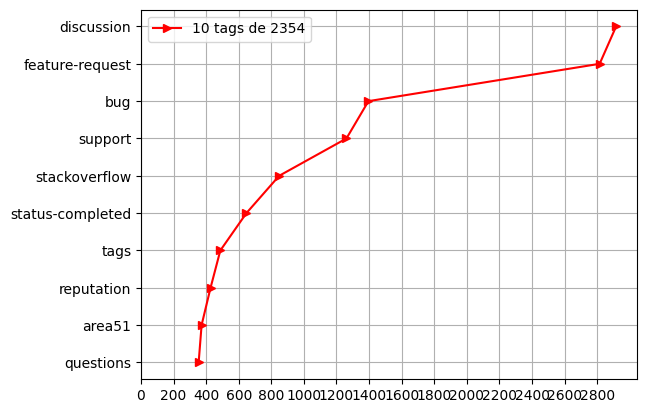

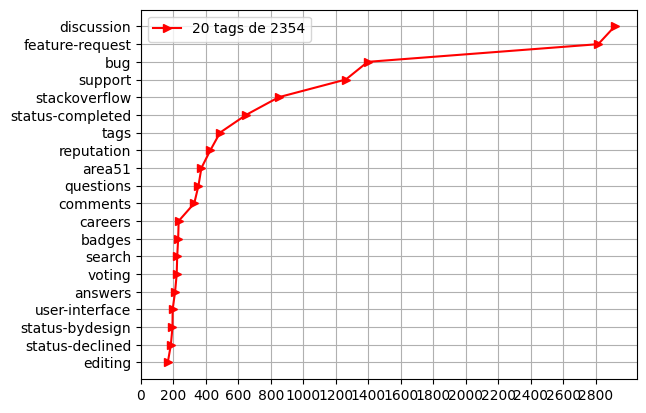

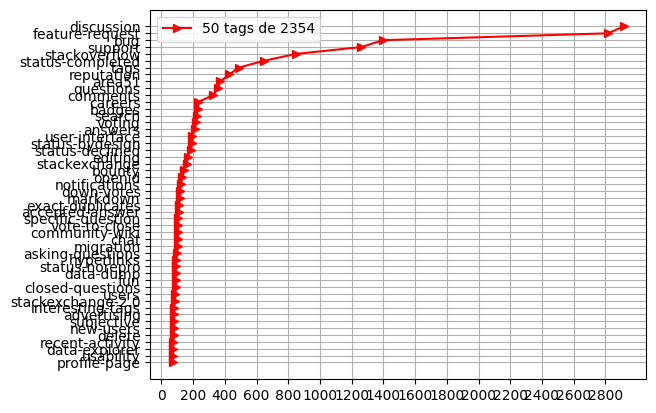

In [72]:
df_1 = df_1.sort_values(by=['Count'],ascending=True) #Cambiamos el orden para una mejor visualización

for x in [10,20,50]:
    n_tags = x     #Esta variable controlara la cantidad de tags a graficar
    plt.plot(df_1['Count'].tail(n_tags),df_1['Tag'].tail(n_tags),label=f'{n_tags} tags de {df_1.size}',color='red',marker='>')
    plt.xticks(np.arange(0,3000,200))
    plt.legend()
    plt.grid()
    plt.show()

#n_tags = 10     #Esta variable controlara la cantidad de tags a graficar
#plt.plot(df_1['Count'].tail(n_tags),df_1['Tag'].tail(n_tags),label='etiqueta de los datos',color='red',marker='>')
#plt.show()

Como podemos apreciar, en este grupo de datos (sin respuestas aceptadas) hay una clara utilización de ciertos tags por sobre el total de los que se usan en Stack Overflow. Vamos a marcar el punto de quiebre donde se disparan los de mayor frecuencia.

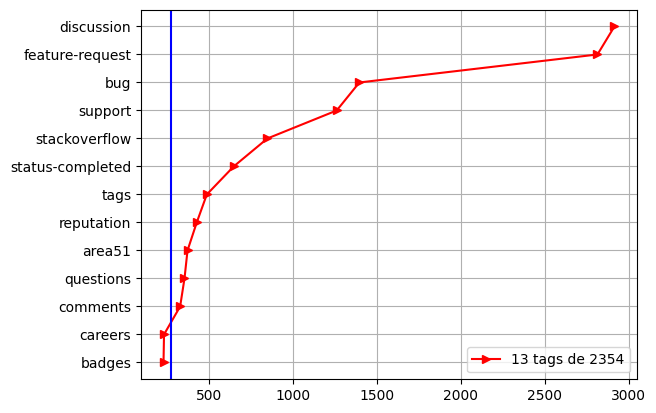

In [79]:
n_tags = 13
plt.plot(df_1['Count'].tail(n_tags),df_1['Tag'].tail(n_tags),label=f'{n_tags} tags de {df_1.size}',color='red',marker='>')
plt.axvline(x=275,color='blue')
plt.legend()
plt.grid()
plt.show()

### Conclusión

Al ver los ya obtenidos top 10 de los tags de esta selección, se destaca de sobremanera como ellos encabezan junto con un onceavo tag (comments) la lista por sobre cualquier otro valor.

No obstante, vincular su uso con la no aceptación de una respuesta es, quizás, muy apresurado, ya que las cuatro principales corresponden a tags que se esperan que se utilicen con gran frecuencia por la comunidad. Sería necesario un analisis más profundo donde se cubra más atributos para confirmar o negar alguna suposición al respecto.

### 2º Requisito

Empezaremos por recuperar los datos obtenidos en la etapa de preprocesamiento

In [107]:
#Cargamos los datos nuevamente para su manipulación
with open(path_note.replace('/notebooks',f'/outputs/GB_requerimiento_2.txt'),'r') as f:
        view_words_data = f.read()                    
        f.close()
data_2 = eval(view_words_data)

#Creamos un DataFrame con estos datos
df_2 = pd.DataFrame(data_2,columns=['View','Words'])

Esta vez acompañaremos la visualización de los datos con la correlación entre estas feactures, y tener una idea más clara de la dependencia y variación de una con la otra

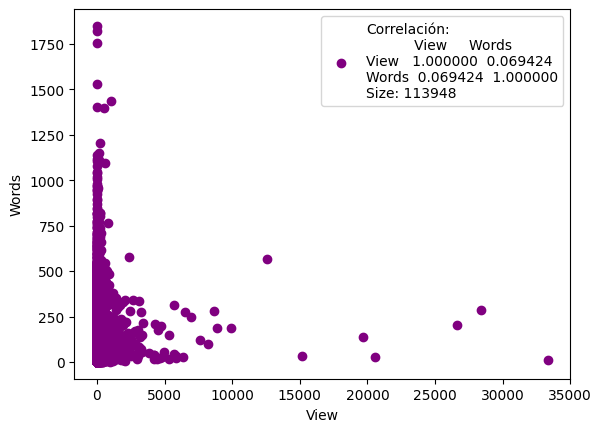

In [140]:
plt.scatter(df_2['View'],df_2['Words'],color='purple',
label=f'Correlación:\n{df_2.corr()}\nSize: {df_2.size}') #Crea un diagrama de dispersión
plt.xlabel('View')
plt.ylabel('Words')
plt.legend()
plt.show()

Utilizando los datos tal cual se extraen, se puede apreciar como se niega una relación proporcional entre las variables, y como todos los datos parecen concentrarse en un rango de vistas sin importar la cantidad de palabras. También se hace muy evidente la presencia de Outliers, así que antes que nada, procederemos a eliminarlos.

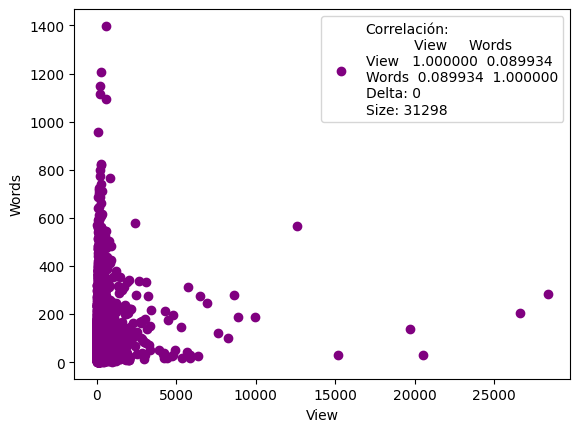

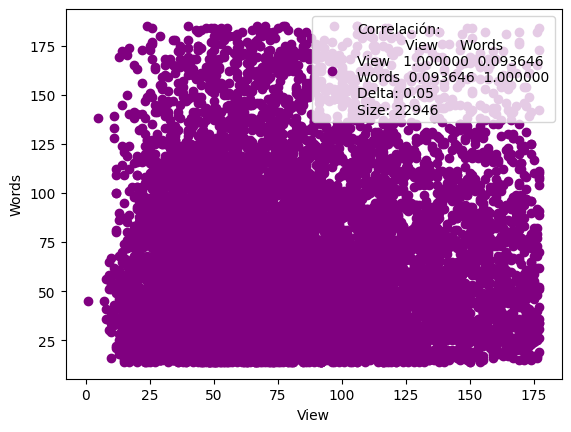

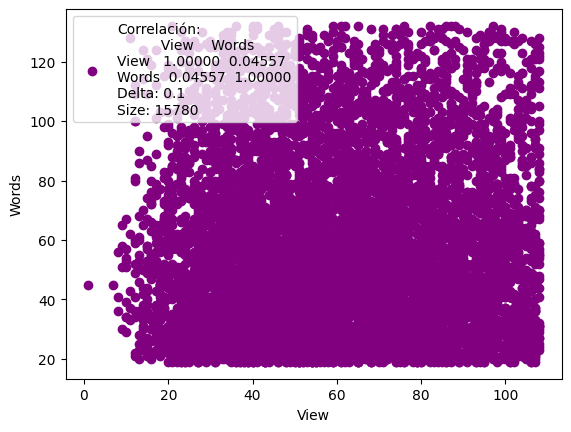

In [139]:
#Crearé una función para la eliminación de outliers según los quantiles que registre cada variable

def outlier_cleaning(data,features,delta):
    clean_data = data
    for x in features:
        min = clean_data[x].quantile(0+delta)
        max = clean_data[x].quantile(1-delta)
        clean_data = clean_data[(clean_data[x]<max)&(clean_data[x]>min)]
    return clean_data

for x in [0,0.05,0.1]:
    clean_data_2 = outlier_cleaning(df_2,['View','Words'],x)

    plt.scatter(clean_data_2['View'],clean_data_2['Words'],color='purple',
    label=f'Correlación:\n{clean_data_2.corr()}\nDelta: {x}\nSize: {clean_data_2.size}')
    plt.xlabel('View')
    plt.ylabel('Words')
    plt.legend()
    plt.show()

### Conclusión

Se puede apreciar como a medida de que nos vamos acercando a la "nube de datos", la cantidad de registros cae drásticamente. Con solo quitar los datos fuera de los quantiles 0 y 1, ¡Ya se desaparece un 73% de los datos! Esta enorme dispersión de los datos fuera de la nube, a pesar de la presencia de esta última, nos habla de como no existe una conexión directa entre las features analizadas.

### 3º Requisito

Empezaremos por recuperar los datos obtenidos en la etapa de preprocesamiento

In [159]:
#Cargamos los datos nuevamente para su manipulación
with open(path_note.replace('/notebooks',f'/outputs/GB_requerimiento_3.txt'),'r') as f:
        answer_score_data = f.read()                    
        f.close()
data_3 = eval(answer_score_data)

#Creamos un DataFrame con estos datos
df_3 = pd.DataFrame(data_3,columns=['Id','Score','Favorite'])

Lo primero a revisar, es la cantidad de datos con pocos favoritos. Esta nueva limpieza se vuelve necesaria ya que el método elegido para la selección de preguntas con más favoritos se baso en ordenar y extraer la capa superior. Ahora que podemos visualizarlos mejor, veremos si hace falta recortar más para cumplir nuestra consigna.

In [178]:
#Mostramos la cantidad de post con cada cantidad de favoritos que poseen
(df_3['Favorite'].value_counts()).sort_values(ascending=False).head(10)

3     1659
4      709
5      607
2      598
7      440
8      386
10     364
6      339
83     292
11     215
Name: Favorite, dtype: int64

Destaca a simple vista, como se han filtrado post con muy bajos favoritos comparados con otros, y que por lo tanto procederemos a ignorar previo a graficar y calcular lo solicitado.

In [179]:
clean_df_3 = df_3[df_3['Favorite']>10]

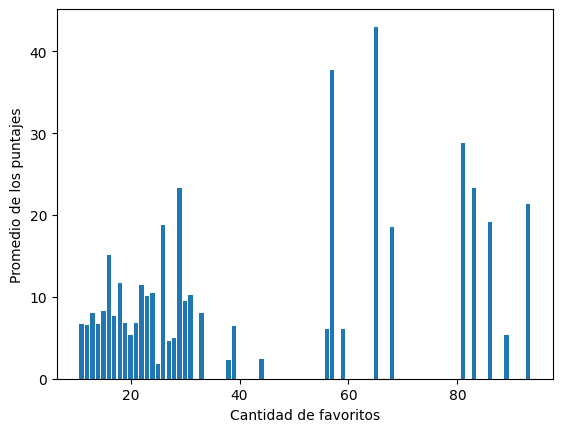

In [213]:
fav = clean_df_3['Favorite'].unique()
fav.sort()

means = []                                #Los promedios solicitados ya quedan almacenados aquí
for x in fav:
    y = clean_df_3[clean_df_3['Favorite']==x]['Score'].mean()
    means.append([x,y])
means

means_df = pd.DataFrame(means, columns=['Favorite','Mean'])
plt.bar(means_df.Favorite,means_df.Mean)
plt.xlabel('Cantidad de favoritos') 
plt.ylabel('Promedio de los puntajes') 
plt.show()


### Conclusiones

Se puede apreciar como los puntajes se mantienen altos en las preguntas con más favoritos. No obstante, tanto en la gráfica como en los datos que eliminamos, se puede ver como son muchos más los post con pocos favoritos y, al descartarlos de esta muestra, no se puede hacer un análisis de sus puntajes, ni deducir si estas variables estan relacionadas a nivel global. De momento, se han obtenido los requisitos solicitados.